# Face Recognition on LFW Dataset
## Comparing Deep Learning Backbones and Classical Classifiers

In [1]:
import os
import tarfile
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from pathlib import Path
from tqdm.auto import tqdm
import joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision.transforms as transforms
from torchvision import models

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, roc_curve, classification_report,
                             log_loss)

try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpus = torch.cuda.device_count()
print(f"Device: {device}, GPUs: {n_gpus}")

Device: cuda, GPUs: 2


In [ ]:
INPUT_DIR = '/kaggle/input/lfw-dataset'
WORK_DIR = '/kaggle/working'
DATA_DIR = os.path.join(WORK_DIR, 'lfw_deepfunneled')

tgz_path = os.path.join(INPUT_DIR, 'lfw-funneled.tgz')
if not os.path.exists(DATA_DIR):
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(WORK_DIR)
    print(f"Extracted to {DATA_DIR}")
else:
    print(f"Data already extracted at {DATA_DIR}")

Extracted to /kaggle/working/lfw_funneled


## Data Loading and Preprocessing

In [3]:
def parse_pairs_file(filepath, data_dir):
    pairs = []
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    first_line = lines[0].strip().split()
    start_idx = 0 if len(first_line) >= 3 else 1
    
    for line in lines[start_idx:]:
        parts = line.strip().split('\t')
        if len(parts) == 3:
            name, idx1, idx2 = parts
            img1 = os.path.join(data_dir, name, f"{name}_{int(idx1):04d}.jpg")
            img2 = os.path.join(data_dir, name, f"{name}_{int(idx2):04d}.jpg")
            pairs.append((img1, img2, 1))
        elif len(parts) == 4:
            name1, idx1, name2, idx2 = parts
            img1 = os.path.join(data_dir, name1, f"{name1}_{int(idx1):04d}.jpg")
            img2 = os.path.join(data_dir, name2, f"{name2}_{int(idx2):04d}.jpg")
            pairs.append((img1, img2, 0))
    return pairs

train_pairs = parse_pairs_file(os.path.join(INPUT_DIR, 'pairsDevTrain.txt'), DATA_DIR)
test_pairs = parse_pairs_file(os.path.join(INPUT_DIR, 'pairsDevTest.txt'), DATA_DIR)
all_pairs = parse_pairs_file(os.path.join(INPUT_DIR, 'pairs.txt'), DATA_DIR)

print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}, All pairs: {len(all_pairs)}")

Train pairs: 2200, Test pairs: 1000, All pairs: 6000


In [4]:
def validate_pairs(pairs):
    valid = [(p1, p2, l) for p1, p2, l in pairs if os.path.exists(p1) and os.path.exists(p2)]
    return valid

train_pairs = validate_pairs(train_pairs)
test_pairs = validate_pairs(test_pairs)
print(f"Valid train pairs: {len(train_pairs)}, Valid test pairs: {len(test_pairs)}")

Valid train pairs: 2200, Valid test pairs: 1000


## Exploratory Data Analysis

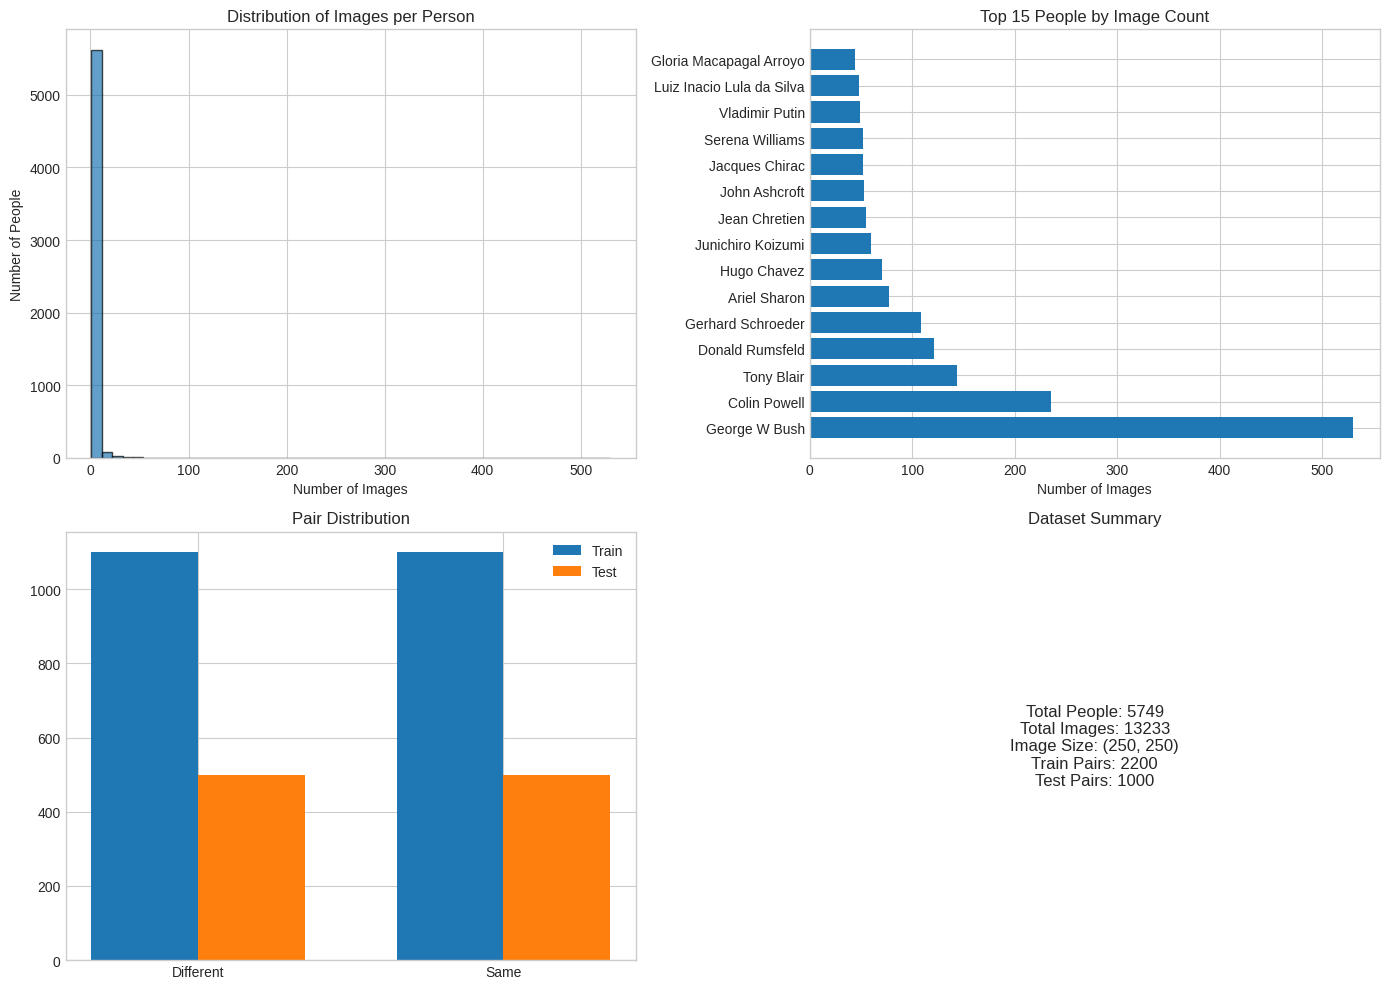

In [5]:
people_dirs = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
images_per_person = {p: len(os.listdir(os.path.join(DATA_DIR, p))) for p in people_dirs}
img_counts = list(images_per_person.values())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(img_counts, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Images')
axes[0, 0].set_ylabel('Number of People')
axes[0, 0].set_title('Distribution of Images per Person')

top_people = sorted(images_per_person.items(), key=lambda x: x[1], reverse=True)[:15]
axes[0, 1].barh([p[0].replace('_', ' ') for p in top_people], [p[1] for p in top_people])
axes[0, 1].set_xlabel('Number of Images')
axes[0, 1].set_title('Top 15 People by Image Count')

train_labels = [p[2] for p in train_pairs]
test_labels = [p[2] for p in test_pairs]
x = np.arange(2)
width = 0.35
axes[1, 0].bar(x - width/2, [train_labels.count(0), train_labels.count(1)], width, label='Train')
axes[1, 0].bar(x + width/2, [test_labels.count(0), test_labels.count(1)], width, label='Test')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Different', 'Same'])
axes[1, 0].legend()
axes[1, 0].set_title('Pair Distribution')

sample_img = Image.open(train_pairs[0][0])
axes[1, 1].text(0.5, 0.5, f"Total People: {len(people_dirs)}\nTotal Images: {sum(img_counts)}\n"
                f"Image Size: {sample_img.size}\nTrain Pairs: {len(train_pairs)}\nTest Pairs: {len(test_pairs)}",
                ha='center', va='center', fontsize=12, transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')
axes[1, 1].set_title('Dataset Summary')

plt.tight_layout()
plt.show()

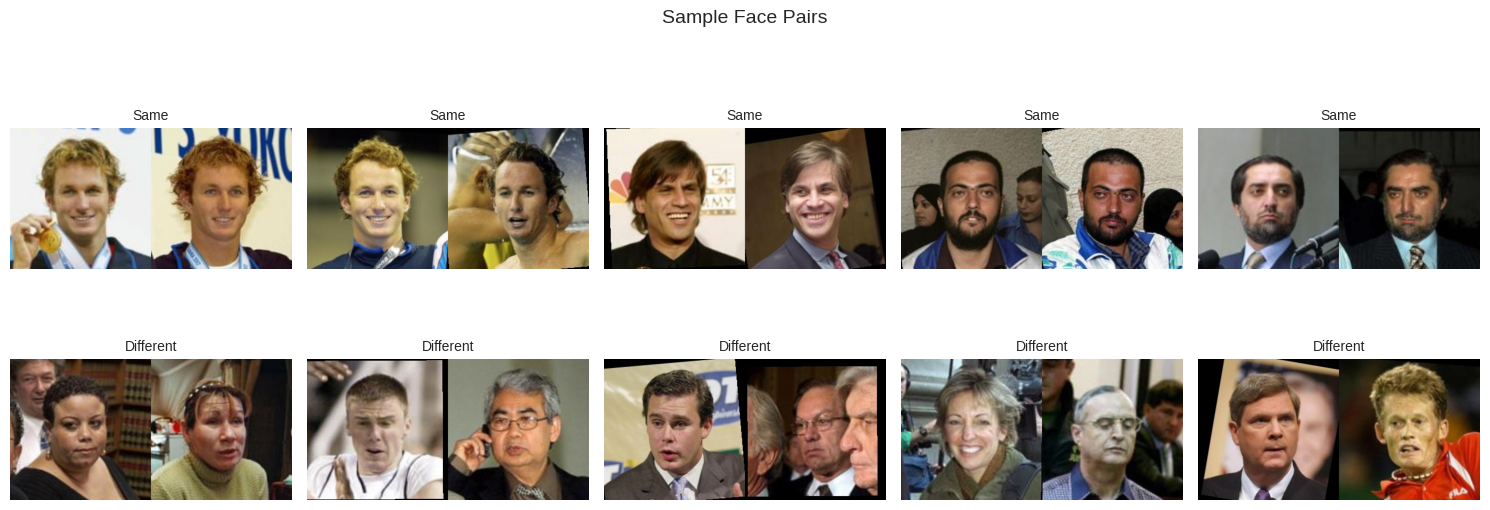

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(5):
    img1 = Image.open(train_pairs[i][0])
    img2 = Image.open(train_pairs[i][1])
    label = "Same" if train_pairs[i][2] == 1 else "Different"
    
    combined = Image.new('RGB', (img1.width * 2, img1.height))
    combined.paste(img1, (0, 0))
    combined.paste(img2, (img1.width, 0))
    
    axes[i].imshow(combined)
    axes[i].set_title(label, fontsize=10)
    axes[i].axis('off')

for i in range(5, 10):
    idx = len(train_pairs) - (i - 4)
    img1 = Image.open(train_pairs[idx][0])
    img2 = Image.open(train_pairs[idx][1])
    label = "Same" if train_pairs[idx][2] == 1 else "Different"
    
    combined = Image.new('RGB', (img1.width * 2, img1.height))
    combined.paste(img1, (0, 0))
    combined.paste(img2, (img1.width, 0))
    
    axes[i].imshow(combined)
    axes[i].set_title(label, fontsize=10)
    axes[i].axis('off')

plt.suptitle('Sample Face Pairs', fontsize=14)
plt.tight_layout()
plt.show()

## Dataset and DataLoader Creation

In [7]:
class FacePairDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.tensor(label, dtype=torch.float32)

IMG_SIZE = 299

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 16 * max(1, n_gpus)

train_dataset = FacePairDataset(train_pairs, transform=train_transform)
test_dataset = FacePairDataset(test_pairs, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Image size: {IMG_SIZE}x{IMG_SIZE}, Batch size: {BATCH_SIZE}")

Image size: 299x299, Batch size: 32


## Model Architecture Definitions

In [8]:
def get_backbone(name, pretrained=True):
    if name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        out_features = model.fc.in_features
        model.fc = nn.Identity()
    elif name == 'efficientnet':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
        out_features = model.classifier[1].in_features
        model.classifier = nn.Identity()
    elif name == 'densenet':
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)
        out_features = model.classifier.in_features
        model.classifier = nn.Identity()
    elif name == 'mobilenet':
        model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2 if pretrained else None)
        out_features = model.classifier[0].in_features
        model.classifier = nn.Identity()
    elif name == 'inception':
        model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1 if pretrained else None)
        model.aux_logits = False
        out_features = model.fc.in_features
        model.fc = nn.Identity()
    else:
        raise ValueError(f"Unknown backbone: {name}")
    return model, out_features

class NeckModule(nn.Module):
    def __init__(self, in_features, embedding_dim=512):
        super().__init__()
        self.neck = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
    
    def forward(self, x):
        return self.neck(x)

class EmbeddingNetwork(nn.Module):
    def __init__(self, backbone_name='resnet50', embedding_dim=512, pretrained=True):
        super().__init__()
        self.backbone_name = backbone_name
        self.backbone, out_features = get_backbone(backbone_name, pretrained)
        self.neck = NeckModule(out_features, embedding_dim)
    
    def forward_one(self, x):
        features = self.backbone(x)
        if isinstance(features, tuple):
            features = features[0]
        embedding = self.neck(features)
        return F.normalize(embedding, p=2, dim=1)
    
    def forward(self, x1, x2):
        emb1 = self.forward_one(x1)
        emb2 = self.forward_one(x2)
        return emb1, emb2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
    
    def forward(self, emb1, emb2, label):
        distance = F.pairwise_distance(emb1, emb2)
        loss = label * distance.pow(2) + (1 - label) * F.relu(self.margin - distance).pow(2)
        return loss.mean()

BACKBONES = ['resnet50', 'efficientnet', 'densenet', 'mobilenet', 'inception']
CLASSIFIERS = {
    'SVM-RBF': lambda: SVC(kernel='rbf', probability=True, random_state=SEED, C=1.0, gamma='scale'),
    'SVM-Linear': lambda: SVC(kernel='linear', probability=True, random_state=SEED, C=1.0),
    'RandomForest': lambda: RandomForestClassifier(n_estimators=200, max_depth=20, random_state=SEED, n_jobs=-1),
    'LogisticRegression': lambda: LogisticRegression(max_iter=1000, random_state=SEED, n_jobs=-1)
}
if HAS_XGB:
    CLASSIFIERS['XGBoost'] = lambda: xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=SEED, eval_metric='logloss')

## Training Utilities

In [9]:
def train_embedding_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for img1, img2, labels in loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            emb1, emb2 = model(img1, img2)
            loss = criterion(emb1, emb2, labels)
            
            dist = F.pairwise_distance(emb1, emb2)
            preds = (dist < 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    
    return total_loss / len(loader), correct / total

def validate_embedding_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for img1, img2, labels in loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                if hasattr(model, 'module'):
                    emb1, emb2 = model.module(img1, img2)
                else:
                    emb1, emb2 = model(img1, img2)
                loss = criterion(emb1, emb2, labels)
                
                dist = F.pairwise_distance(emb1, emb2)
                preds = (dist < 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
            total_loss += loss.item()
            
    return total_loss / len(loader), correct / total

def extract_embeddings(model, loader, device):
    model.eval()
    embeddings1, embeddings2, labels_list = [], [], []
    
    with torch.no_grad():
        for img1, img2, labels in loader:
            img1, img2 = img1.to(device), img2.to(device)
            if hasattr(model, 'module'):
                emb1, emb2 = model.module(img1, img2)
            else:
                emb1, emb2 = model(img1, img2)
            embeddings1.append(emb1.cpu().numpy())
            embeddings2.append(emb2.cpu().numpy())
            labels_list.extend(labels.numpy())
    
    emb1 = np.vstack(embeddings1)
    emb2 = np.vstack(embeddings2)
    labels = np.array(labels_list)
    
    diff = np.abs(emb1 - emb2)
    prod = emb1 * emb2
    features = np.hstack([emb1, emb2, diff, prod])
    
    return features, labels

def train_backbone(backbone_name, train_loader, test_loader, epochs, lr, device):
    model = EmbeddingNetwork(backbone_name=backbone_name, embedding_dim=512)
    if n_gpus > 1:
        model = nn.DataParallel(model)
    model = model.to(device)
    
    criterion = ContrastiveLoss(margin=1.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = GradScaler()
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    pbar = tqdm(range(epochs), desc=f"Training {backbone_name}")
    for epoch in pbar:
        train_loss, train_acc = train_embedding_epoch(model, train_loader, criterion, optimizer, scaler, device)
        val_loss, val_acc = validate_embedding_epoch(model, test_loader, criterion, device)
        
        scheduler.step()
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        pbar.set_postfix({
            'loss': f"{train_loss:.4f}", 
            'val_loss': f"{val_loss:.4f}",
            'acc': f"{train_acc:.4f}",
            'val_acc': f"{val_acc:.4f}"
        })
    
    return model, history

def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    
    # Train predictions and metrics
    train_preds = clf.predict(X_train)
    train_probs = clf.predict_proba(X_train)[:, 1]
    train_acc = accuracy_score(y_train, train_preds)
    train_loss = log_loss(y_train, train_probs)
    
    # Test predictions and metrics
    test_preds = clf.predict(X_test)
    test_probs = clf.predict_proba(X_test)[:, 1]
    test_acc = accuracy_score(y_test, test_preds)
    test_loss = log_loss(y_test, test_probs)
    
    return {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'f1': f1_score(y_test, test_preds),
        'precision': precision_score(y_test, test_preds),
        'recall': recall_score(y_test, test_preds),
        'roc_auc': roc_auc_score(y_test, test_probs)
    }, test_preds, test_probs

In [10]:
EPOCHS = 10
LEARNING_RATE = 1e-4

backbone_models = {}
backbone_histories = {}
backbone_features = {}

## Train All Backbones (Backbone + Neck)

In [11]:
# Create directory for saving models
MODELS_DIR = 'model'
os.makedirs(MODELS_DIR, exist_ok=True)

for backbone_name in BACKBONES:
    print(f"\n{'='*50}")
    print(f"Training {backbone_name.upper()} backbone...")
    print(f"{'='*50}")
    
    model, history = train_backbone(backbone_name, train_loader, test_loader, EPOCHS, LEARNING_RATE, device)
    backbone_models[backbone_name] = model
    backbone_histories[backbone_name] = history
    
    # Save the backbone model
    model_to_save = model.module if hasattr(model, 'module') else model
    model_path = os.path.join(MODELS_DIR, f'{backbone_name}_backbone.pth')
    torch.save({
        'model_state_dict': model_to_save.state_dict(),
        'backbone_name': backbone_name,
        'embedding_dim': 512,
        'history': history
    }, model_path)
    print(f"Saved backbone model to {model_path}")
    
    print(f"Extracting features from {backbone_name}...")
    X_train, y_train = extract_embeddings(model, train_loader, device)
    X_test, y_test = extract_embeddings(model, test_loader, device)
    
    scaler_feat = StandardScaler()
    X_train_scaled = scaler_feat.fit_transform(X_train)
    X_test_scaled = scaler_feat.transform(X_test)
    
    # Save the scaler for this backbone
    scaler_path = os.path.join(MODELS_DIR, f'{backbone_name}_scaler.joblib')
    joblib.dump(scaler_feat, scaler_path)
    print(f"Saved scaler to {scaler_path}")
    
    backbone_features[backbone_name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    }
    print(f"Features shape: Train {X_train_scaled.shape}, Test {X_test_scaled.shape}")


Training RESNET50 backbone...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


Training resnet50:   0%|          | 0/10 [00:00<?, ?it/s]

Saved backbone model to model/resnet50_backbone.pth
Extracting features from resnet50...
Saved scaler to model/resnet50_scaler.joblib
Features shape: Train (2200, 2048), Test (1000, 2048)

Training EFFICIENTNET backbone...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 153MB/s]


Training efficientnet:   0%|          | 0/10 [00:00<?, ?it/s]

Saved backbone model to model/efficientnet_backbone.pth
Extracting features from efficientnet...
Saved scaler to model/efficientnet_scaler.joblib
Features shape: Train (2200, 2048), Test (1000, 2048)

Training DENSENET backbone...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 154MB/s]


Training densenet:   0%|          | 0/10 [00:00<?, ?it/s]

Saved backbone model to model/densenet_backbone.pth
Extracting features from densenet...
Saved scaler to model/densenet_scaler.joblib
Features shape: Train (2200, 2048), Test (1000, 2048)

Training MOBILENET backbone...
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 151MB/s]


Training mobilenet:   0%|          | 0/10 [00:00<?, ?it/s]

Saved backbone model to model/mobilenet_backbone.pth
Extracting features from mobilenet...
Saved scaler to model/mobilenet_scaler.joblib
Features shape: Train (2200, 2048), Test (1000, 2048)

Training INCEPTION backbone...
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 179MB/s]


Training inception:   0%|          | 0/10 [00:00<?, ?it/s]

Saved backbone model to model/inception_backbone.pth
Extracting features from inception...
Saved scaler to model/inception_scaler.joblib
Features shape: Train (2200, 2048), Test (1000, 2048)


## Train All Classifiers on Each Backbone

In [12]:
results = {}
all_predictions = {}
trained_classifiers = {} # Store trained classifiers for saving

for backbone_name in BACKBONES:
    print(f"\n{'='*50}")
    print(f"Training classifiers on {backbone_name.upper()} features...")
    print(f"{'='*50}")
    
    feat = backbone_features[backbone_name]
    X_train, X_test = feat['X_train'], feat['X_test']
    y_train, y_test = feat['y_train'], feat['y_test']
    
    for clf_name, clf_fn in CLASSIFIERS.items():
        model_key = f"{backbone_name}+{clf_name}"
        print(f"  Training {clf_name}...", end=" ")
        
        clf = clf_fn()
        metrics, preds, probs = evaluate_classifier(clf, X_train, y_train, X_test, y_test)
        
        results[model_key] = metrics
        all_predictions[model_key] = (y_test, preds, probs)
        trained_classifiers[model_key] = clf
        
        # Save the trained classifier
        clf_path = os.path.join(MODELS_DIR, f'{backbone_name}_{clf_name.replace("-", "_")}_classifier.joblib')
        joblib.dump(clf, clf_path)
        
        print(f"Train Acc: {metrics['train_accuracy']:.4f}, Test Acc: {metrics['test_accuracy']:.4f}, F1: {metrics['f1']:.4f}, AUC: {metrics['roc_auc']:.4f}")

print(f"\n{'='*50}")
print(f"All classifiers saved to '{MODELS_DIR}/' directory")
print(f"{'='*50}")


Training classifiers on RESNET50 features...
  Training SVM-RBF... Train Acc: 0.8877, Test Acc: 0.7950, F1: 0.8027, AUC: 0.8551
  Training SVM-Linear... Train Acc: 0.9955, Test Acc: 0.7690, F1: 0.7591, AUC: 0.8434
  Training RandomForest... Train Acc: 0.9868, Test Acc: 0.8020, F1: 0.8008, AUC: 0.8704
  Training LogisticRegression... Train Acc: 0.9886, Test Acc: 0.7810, F1: 0.7758, AUC: 0.8569
  Training XGBoost... Train Acc: 1.0000, Test Acc: 0.7950, F1: 0.7940, AUC: 0.8765

Training classifiers on EFFICIENTNET features...
  Training SVM-RBF... Train Acc: 0.9014, Test Acc: 0.7850, F1: 0.7844, AUC: 0.8449
  Training SVM-Linear... Train Acc: 0.9982, Test Acc: 0.7630, F1: 0.7387, AUC: 0.8641
  Training RandomForest... Train Acc: 0.9900, Test Acc: 0.7720, F1: 0.7620, AUC: 0.8621
  Training LogisticRegression... Train Acc: 0.9900, Test Acc: 0.7910, F1: 0.7784, AUC: 0.8732
  Training XGBoost... Train Acc: 1.0000, Test Acc: 0.7870, F1: 0.7820, AUC: 0.8755

Training classifiers on DENSENET fe

## Model Evaluation and Comparison

In [13]:
results_df = pd.DataFrame(results).T
results_df = results_df[['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'f1', 'precision', 'recall', 'roc_auc']]
results_df = results_df.sort_values('f1', ascending=False)
print("Model Comparison (sorted by F1 Score):")
display(results_df.style.highlight_max(axis=0, subset=['train_accuracy', 'test_accuracy', 'f1', 'precision', 'recall', 'roc_auc'])
        .highlight_min(axis=0, subset=['train_loss', 'test_loss'])
        .format(precision=4))

Model Comparison (sorted by F1 Score):


,train_accuracy,test_accuracy,train_loss,test_loss,f1,precision,recall,roc_auc
densenet+SVM-RBF,0.9432,0.8390,0.1441,0.5763,0.8338,0.8614,0.8080,0.8971
densenet+LogisticRegression,0.9955,0.8400,0.0284,0.7402,0.8301,0.8846,0.7820,0.9223
densenet+SVM-Linear,0.9991,0.8260,0.0756,0.4861,0.8141,0.8739,0.7620,0.9197
densenet+XGBoost,1.0000,0.8210,0.0030,0.7933,0.8061,0.8794,0.7440,0.9151
resnet50+SVM-RBF,0.8877,0.7950,0.2817,0.5107,0.8027,0.7737,0.8340,0.8551
mobilenet+SVM-RBF,0.8736,0.7960,0.2958,0.5014,0.8012,0.7814,0.8220,0.8649
resnet50+RandomForest,0.9868,0.8020,0.0884,0.5063,0.8008,0.8057,0.7960,0.8704
mobilenet+XGBoost,1.0000,0.8010,0.0061,0.6752,0.8004,0.8028,0.7980,0.8833
densenet+RandomForest,0.9982,0.8150,0.0491,0.5023,0.7978,0.8795,0.7300,0.9125
resnet50+XGBoost,1.0000,0.7950,0.0068,0.7369,0.7940,0.7980,0.7900,0.8765


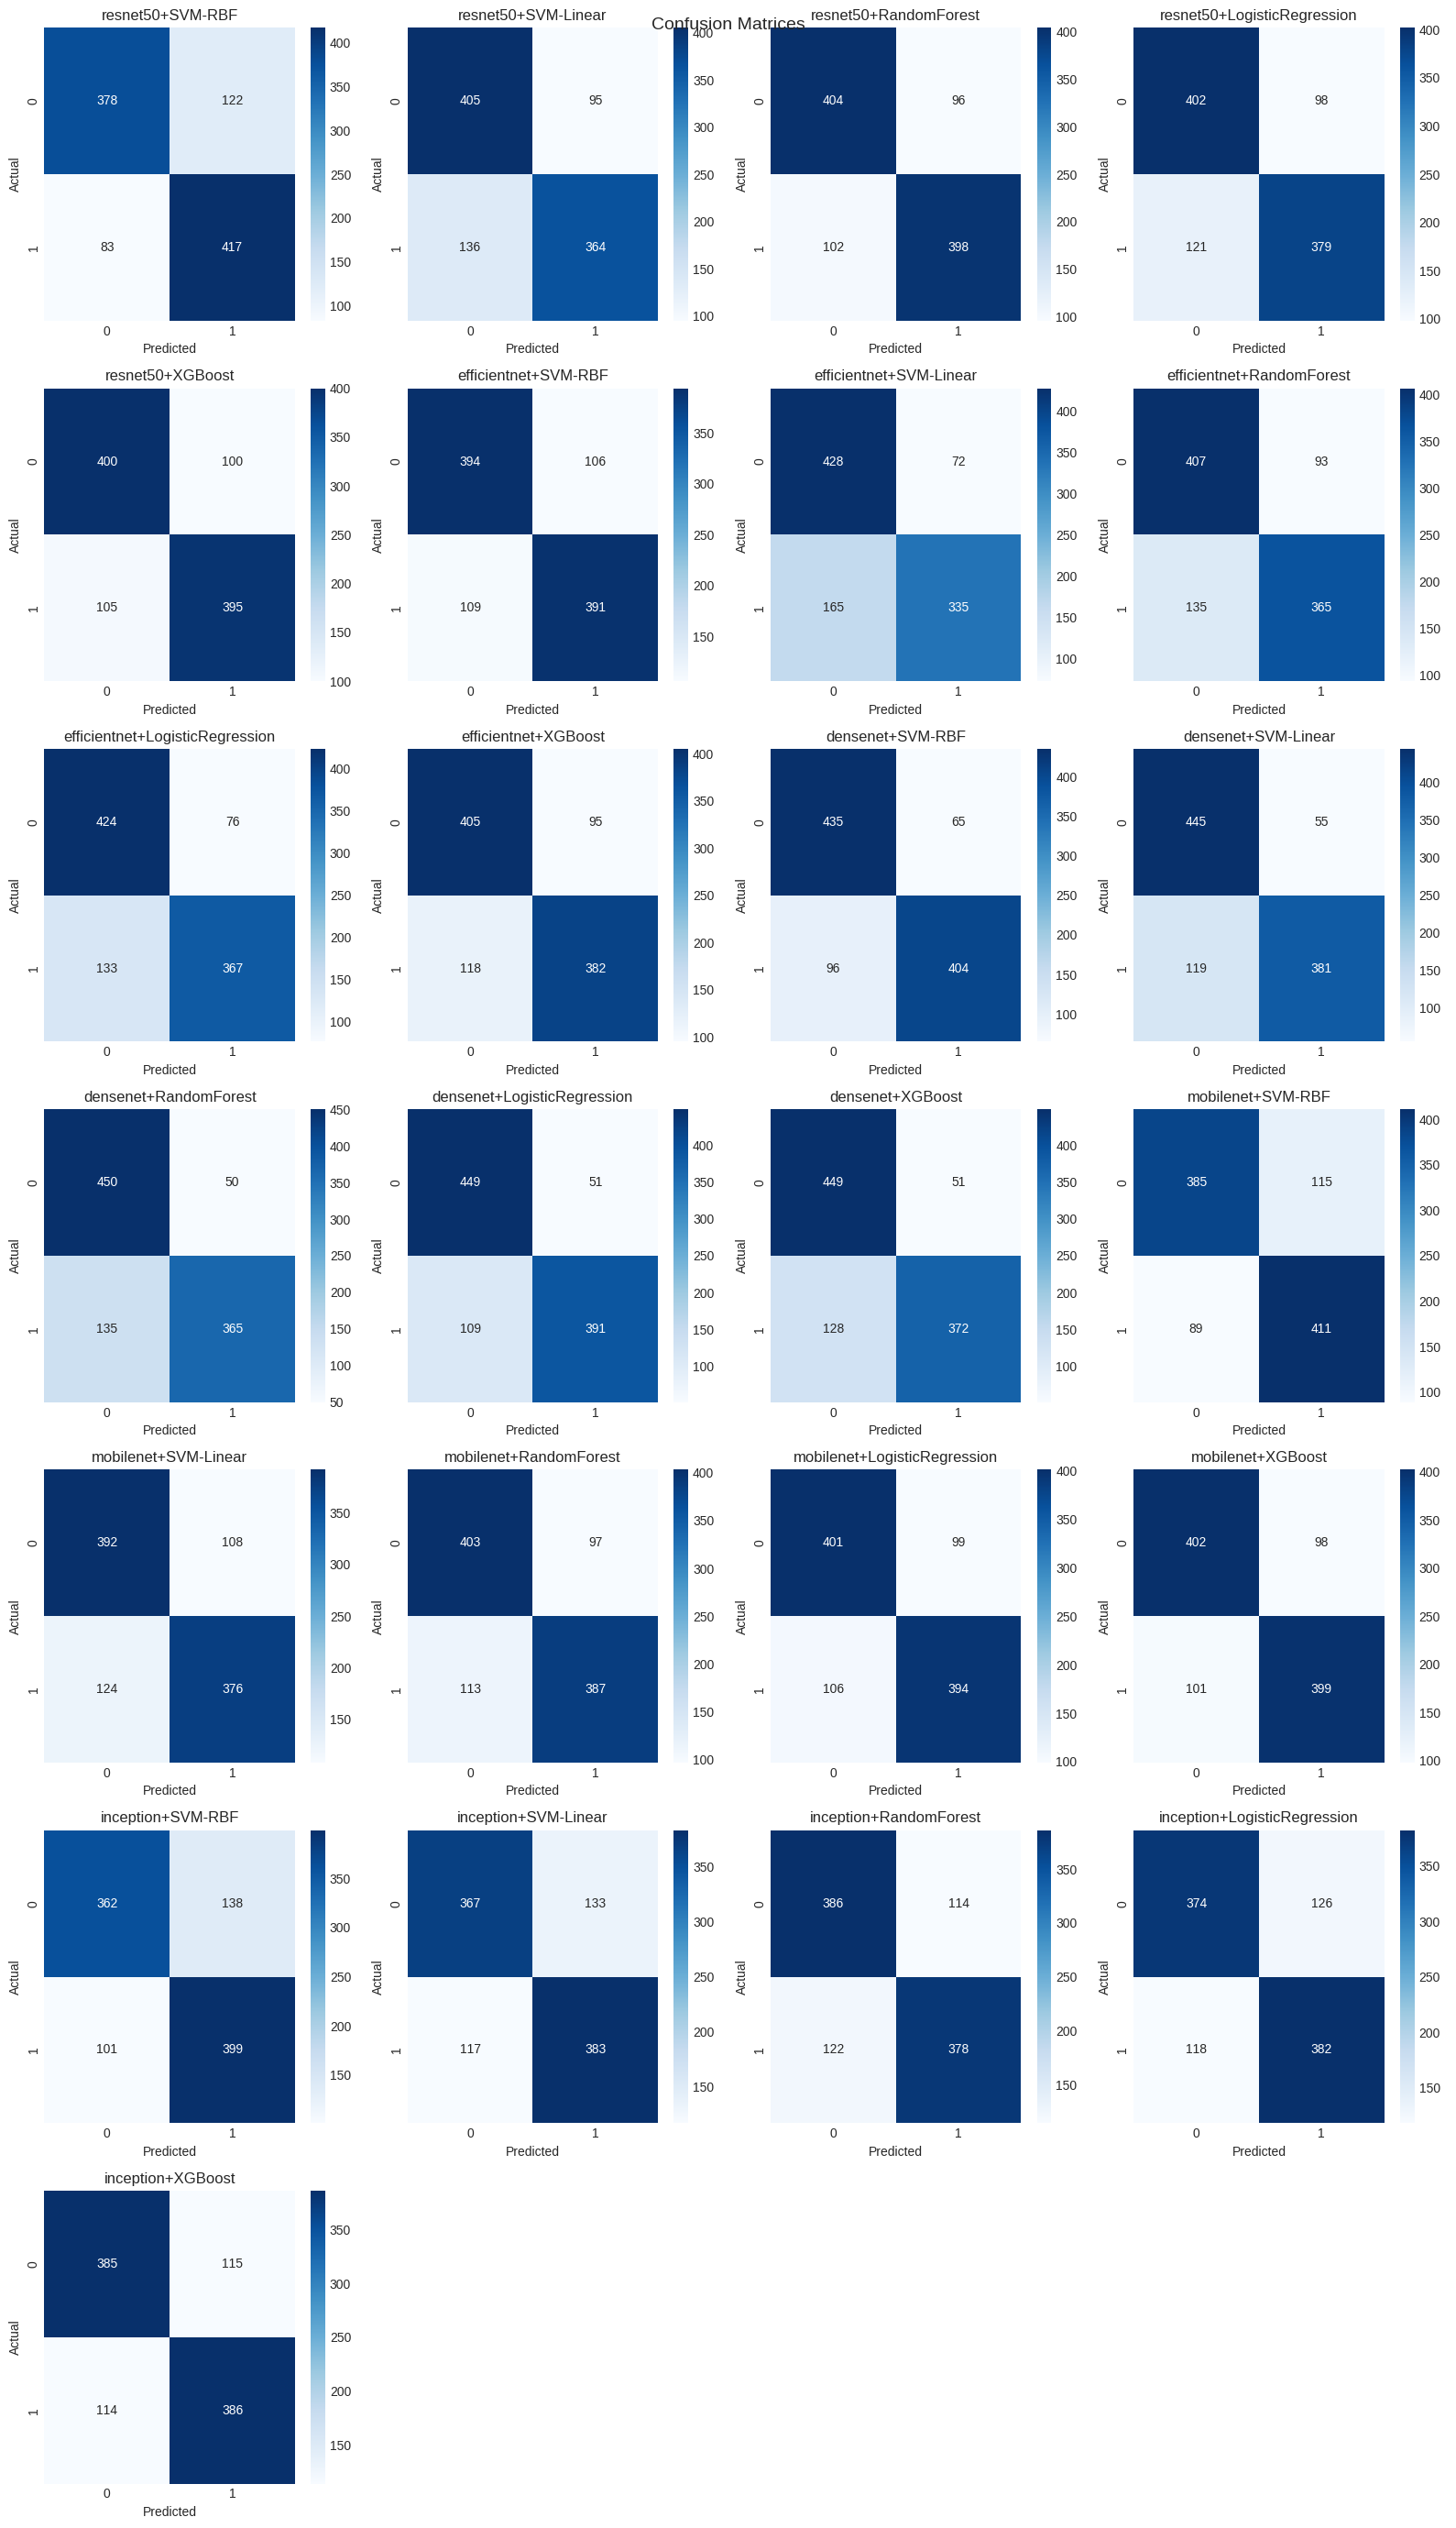

In [14]:
n_models = len(all_predictions)
n_cols = 4
n_rows = (n_models + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for idx, (name, (labels, preds, _)) in enumerate(all_predictions.items()):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

for idx in range(len(all_predictions), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices', fontsize=14)
plt.tight_layout()
plt.show()

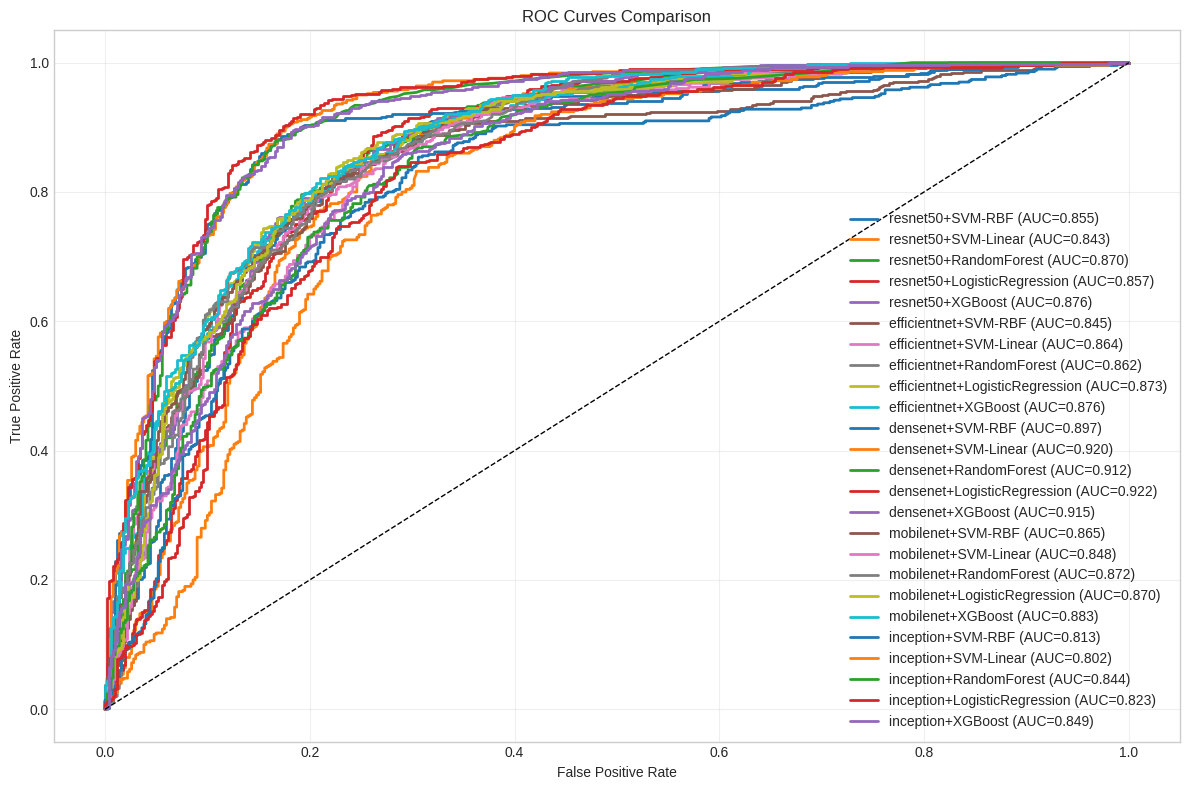

In [15]:
plt.figure(figsize=(12, 8))

for name, (labels, _, probs) in all_predictions.items():
    fpr, tpr, _ = roc_curve(labels, probs)
    auc = roc_auc_score(labels, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Results Visualization

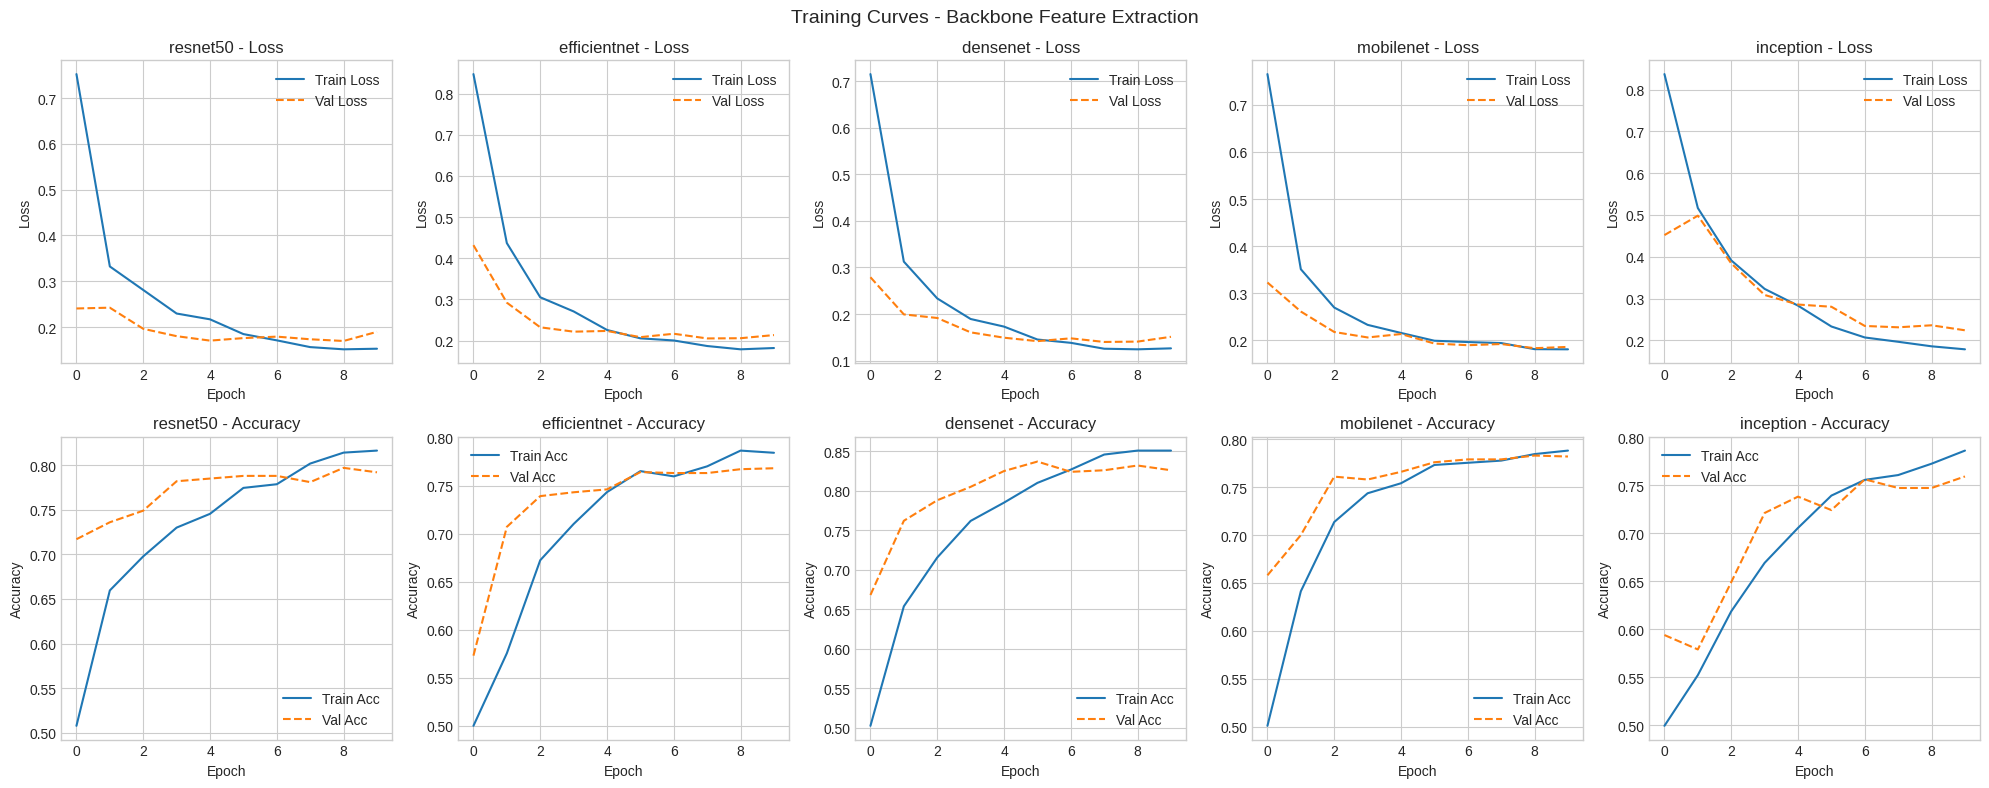

In [16]:
n_backbones = len(backbone_histories)
fig, axes = plt.subplots(2, n_backbones, figsize=(4 * n_backbones, 8))
if n_backbones == 1:
    axes = np.array([axes]).T # Ensure 2 rows
elif hasattr(axes, 'flatten'):
    pass # axes is already 2D array (2, n_backbones)

for idx, (name, hist) in enumerate(backbone_histories.items()):
    # Loss plot
    ax_loss = axes[0, idx] if n_backbones > 1 else axes[0]
    ax_loss.plot(hist['train_loss'], label='Train Loss')
    if 'val_loss' in hist and hist['val_loss']:
        ax_loss.plot(hist['val_loss'], label='Val Loss', linestyle='--')
    ax_loss.set_title(f'{name} - Loss')
    ax_loss.legend()
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')

    # Accuracy plot
    ax_acc = axes[1, idx] if n_backbones > 1 else axes[1]
    if 'train_acc' in hist:
        ax_acc.plot(hist['train_acc'], label='Train Acc')
    if 'val_acc' in hist:
        ax_acc.plot(hist['val_acc'], label='Val Acc', linestyle='--')
    ax_acc.set_title(f'{name} - Accuracy')
    ax_acc.legend()
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy')

plt.suptitle('Training Curves - Backbone Feature Extraction', fontsize=14)
plt.tight_layout()
plt.show()

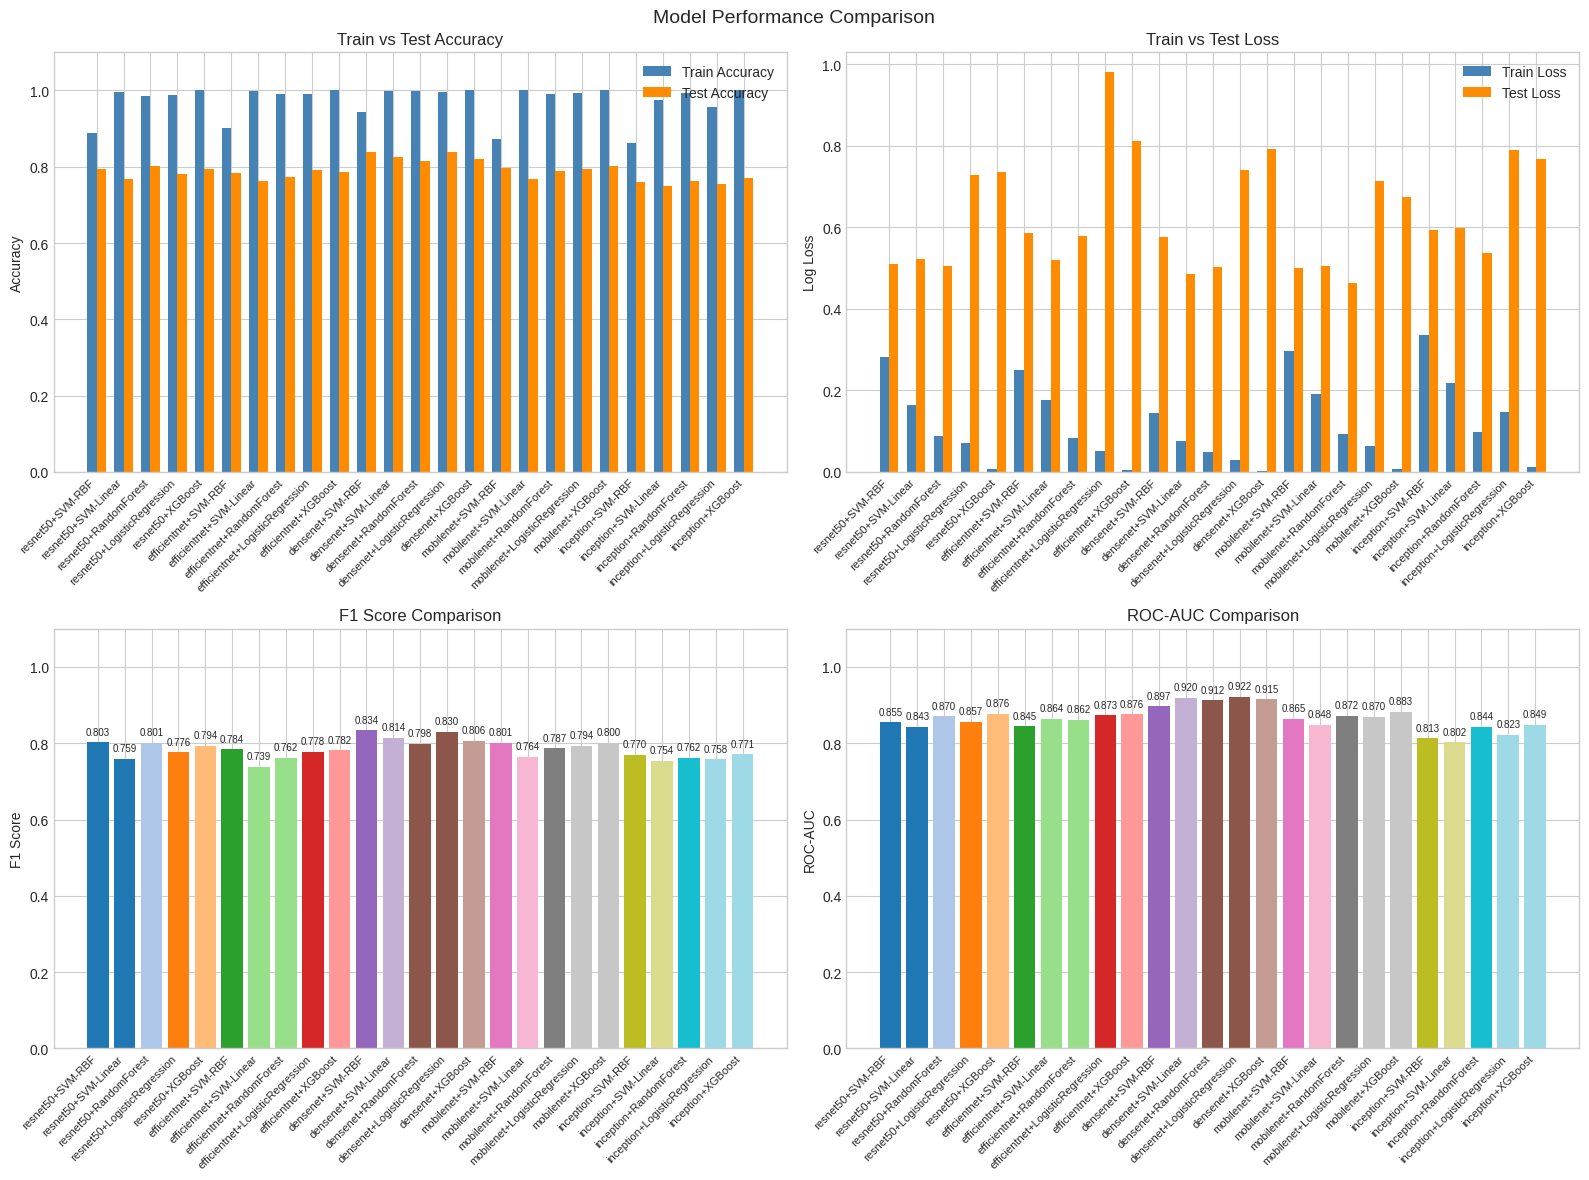

In [17]:
models_list = list(results.keys())
n_models = len(models_list)
colors = plt.cm.tab20(np.linspace(0, 1, n_models))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Train vs Test Accuracy
ax = axes[0, 0]
x = np.arange(n_models)
width = 0.35
train_acc = [results[m]['train_accuracy'] for m in models_list]
test_acc = [results[m]['test_accuracy'] for m in models_list]
ax.bar(x - width/2, train_acc, width, label='Train Accuracy', color='steelblue')
ax.bar(x + width/2, test_acc, width, label='Test Accuracy', color='darkorange')
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Accuracy')
ax.set_title('Train vs Test Accuracy')
ax.legend()
ax.set_ylim(0, 1.1)

# Train vs Test Loss
ax = axes[0, 1]
train_loss = [results[m]['train_loss'] for m in models_list]
test_loss = [results[m]['test_loss'] for m in models_list]
ax.bar(x - width/2, train_loss, width, label='Train Loss', color='steelblue')
ax.bar(x + width/2, test_loss, width, label='Test Loss', color='darkorange')
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Log Loss')
ax.set_title('Train vs Test Loss')
ax.legend()

# F1 Score Comparison
ax = axes[1, 0]
f1_scores = [results[m]['f1'] for m in models_list]
bars = ax.bar(x, f1_scores, color=colors)
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison')
ax.set_ylim(0, 1.1)
for bar, val in zip(bars, f1_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center', fontsize=7)

# ROC-AUC Comparison
ax = axes[1, 1]
roc_scores = [results[m]['roc_auc'] for m in models_list]
bars = ax.bar(x, roc_scores, color=colors)
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC Comparison')
ax.set_ylim(0, 1.1)
for bar, val in zip(bars, roc_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center', fontsize=7)

plt.suptitle('Model Performance Comparison', fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
results_df['Backbone'] = results_df.index.map(lambda x: x.split('+')[0])
results_df['Classifier'] = results_df.index.map(lambda x: x.split('+')[1])

best_model_name = results_df.index[0]
best_metrics = results_df.iloc[0]

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*60}")
print(f"Train Accuracy: {best_metrics['train_accuracy']:.4f}")
print(f"Test Accuracy:  {best_metrics['test_accuracy']:.4f}")
print(f"Train Loss:     {best_metrics['train_loss']:.4f}")
print(f"Test Loss:      {best_metrics['test_loss']:.4f}")
print(f"F1 Score:       {best_metrics['f1']:.4f}")
print(f"Precision:      {best_metrics['precision']:.4f}")
print(f"Recall:         {best_metrics['recall']:.4f}")
print(f"ROC-AUC:        {best_metrics['roc_auc']:.4f}")
print(f"{'='*60}")

print("\n\nTop 10 Model Rankings:")
for i, (idx, row) in enumerate(results_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {idx:30s}: F1={row['f1']:.4f}, TrainAcc={row['train_accuracy']:.4f}, TestAcc={row['test_accuracy']:.4f}, AUC={row['roc_auc']:.4f}")

backbone_avg = results_df.groupby('Backbone')[['f1', 'test_accuracy', 'roc_auc']].mean()
classifier_avg = results_df.groupby('Classifier')[['f1', 'test_accuracy', 'roc_auc']].mean()

print(f"\n\nBest Backbone (avg F1): {backbone_avg['f1'].idxmax()} ({backbone_avg['f1'].max():.4f})")
print(f"Best Classifier (avg F1): {classifier_avg['f1'].idxmax()} ({classifier_avg['f1'].max():.4f})")


BEST MODEL: densenet+SVM-RBF
Train Accuracy: 0.9432
Test Accuracy:  0.8390
Train Loss:     0.1441
Test Loss:      0.5763
F1 Score:       0.8338
Precision:      0.8614
Recall:         0.8080
ROC-AUC:        0.8971


Top 10 Model Rankings:
 1. densenet+SVM-RBF              : F1=0.8338, TrainAcc=0.9432, TestAcc=0.8390, AUC=0.8971
 2. densenet+LogisticRegression   : F1=0.8301, TrainAcc=0.9955, TestAcc=0.8400, AUC=0.9223
 3. densenet+SVM-Linear           : F1=0.8141, TrainAcc=0.9991, TestAcc=0.8260, AUC=0.9197
 4. densenet+XGBoost              : F1=0.8061, TrainAcc=1.0000, TestAcc=0.8210, AUC=0.9151
 5. resnet50+SVM-RBF              : F1=0.8027, TrainAcc=0.8877, TestAcc=0.7950, AUC=0.8551
 6. mobilenet+SVM-RBF             : F1=0.8012, TrainAcc=0.8736, TestAcc=0.7960, AUC=0.8649
 7. resnet50+RandomForest         : F1=0.8008, TrainAcc=0.9868, TestAcc=0.8020, AUC=0.8704
 8. mobilenet+XGBoost             : F1=0.8004, TrainAcc=1.0000, TestAcc=0.8010, AUC=0.8833
 9. densenet+RandomForest        

In [19]:
import json

json_output = []

for model_key, metrics in results.items():
    backbone, classifier = model_key.split('+')
    
    history = backbone_histories.get(backbone, {})
    
    model_data = {
        'model_name': model_key,
        'backbone': backbone,
        'classifier': classifier,
        'epochs': len(history.get('train_loss', [])),
        'backbone_training': {
            'train_loss': history.get('train_loss', []),
            'val_loss': history.get('val_loss', []),
            'train_accuracy': history.get('train_acc', []),
            'val_accuracy': history.get('val_acc', [])
        },
        'classifier_metrics': {
            'train_accuracy': float(metrics.get('train_accuracy', 0.0)),
            'test_accuracy': float(metrics.get('test_accuracy', 0.0)),
            'train_loss': float(metrics.get('train_loss', 0.0)),
            'test_loss': float(metrics.get('test_loss', 0.0)),
            'precision': float(metrics.get('precision', 0.0)),
            'recall': float(metrics.get('recall', 0.0)),
            'f1': float(metrics.get('f1', 0.0)),
            'roc_auc': float(metrics.get('roc_auc', 0.0))
        }
    }
    json_output.append(model_data)

output_file = 'model_results.json'
with open(output_file, 'w') as f:
    json.dump(json_output, f, indent=4)

print(f"Results saved to {output_file}")
print(f"Total models saved: {len(json_output)}")

Results saved to model_results.json
Total models saved: 25
